# Hyperparameter optimisation of a Gaussian Process

In [106]:
%pylab inline  
import GPy
import GPyOpt
import numpy as np
import warnings
import matplotlib.pyplot as plt
import pandas as pd

from numpy.random import seed
from scipy.stats import multivariate_normal as mvn

warnings.filterwarnings('ignore')
seed(12345)

Populating the interactive namespace from numpy and matplotlib


## Load the data

In [79]:
pr_df = pd.read_csv("data_single_uk_point.csv")

training_set = pr_df.iloc[0:80]
test_set = pr_df.iloc[80:100]

In [80]:
x_train = np.linspace(1, 80, 80)

# Renormalise it since they're all approximately *10^-5
y_train = (training_set["pr"].to_numpy())*10**5

x_test = np.linspace(80, 100, 20)
y_test = test_set["pr"].to_numpy()*10**5

x_train.shape, y_train.shape

((80,), (80,))

## Fit a GP to this data

In [81]:
kernel = GPy.kern.RBF(1, lengthscale=2.6, variance=3.5) + GPy.kern.StdPeriodic(1, lengthscale=1.0) * GPy.kern.PeriodicMatern32(1, lengthscale=10, variance=3.5)
model = GPy.models.GPRegression(x_train.reshape(-1, 1), y_train.reshape(-1, 1), kernel=kernel, normalizer= True, noise_var=0.05)

In [82]:
display(model)

GP_regression.,value,constraints,priors
sum.rbf.variance,3.5,+ve,
sum.rbf.lengthscale,2.6,+ve,
sum.mul.std_periodic.variance,1.0,+ve,
sum.mul.std_periodic.period,1.0,+ve,
sum.mul.std_periodic.lengthscale,1.0,+ve,
sum.mul.periodic_Matern32.variance,3.5,+ve,
sum.mul.periodic_Matern32.lengthscale,10.0,+ve,
sum.mul.periodic_Matern32.period,6.283185307179586,+ve,
Gaussian_noise.variance,0.05,+ve,


Find a measure of the loss, e.g. RMSE, using the default parameters.

In [83]:
x_all = np.linspace(1, 100, 100)
y_mean, y_std = model.predict(x_all.reshape(-1, 1))

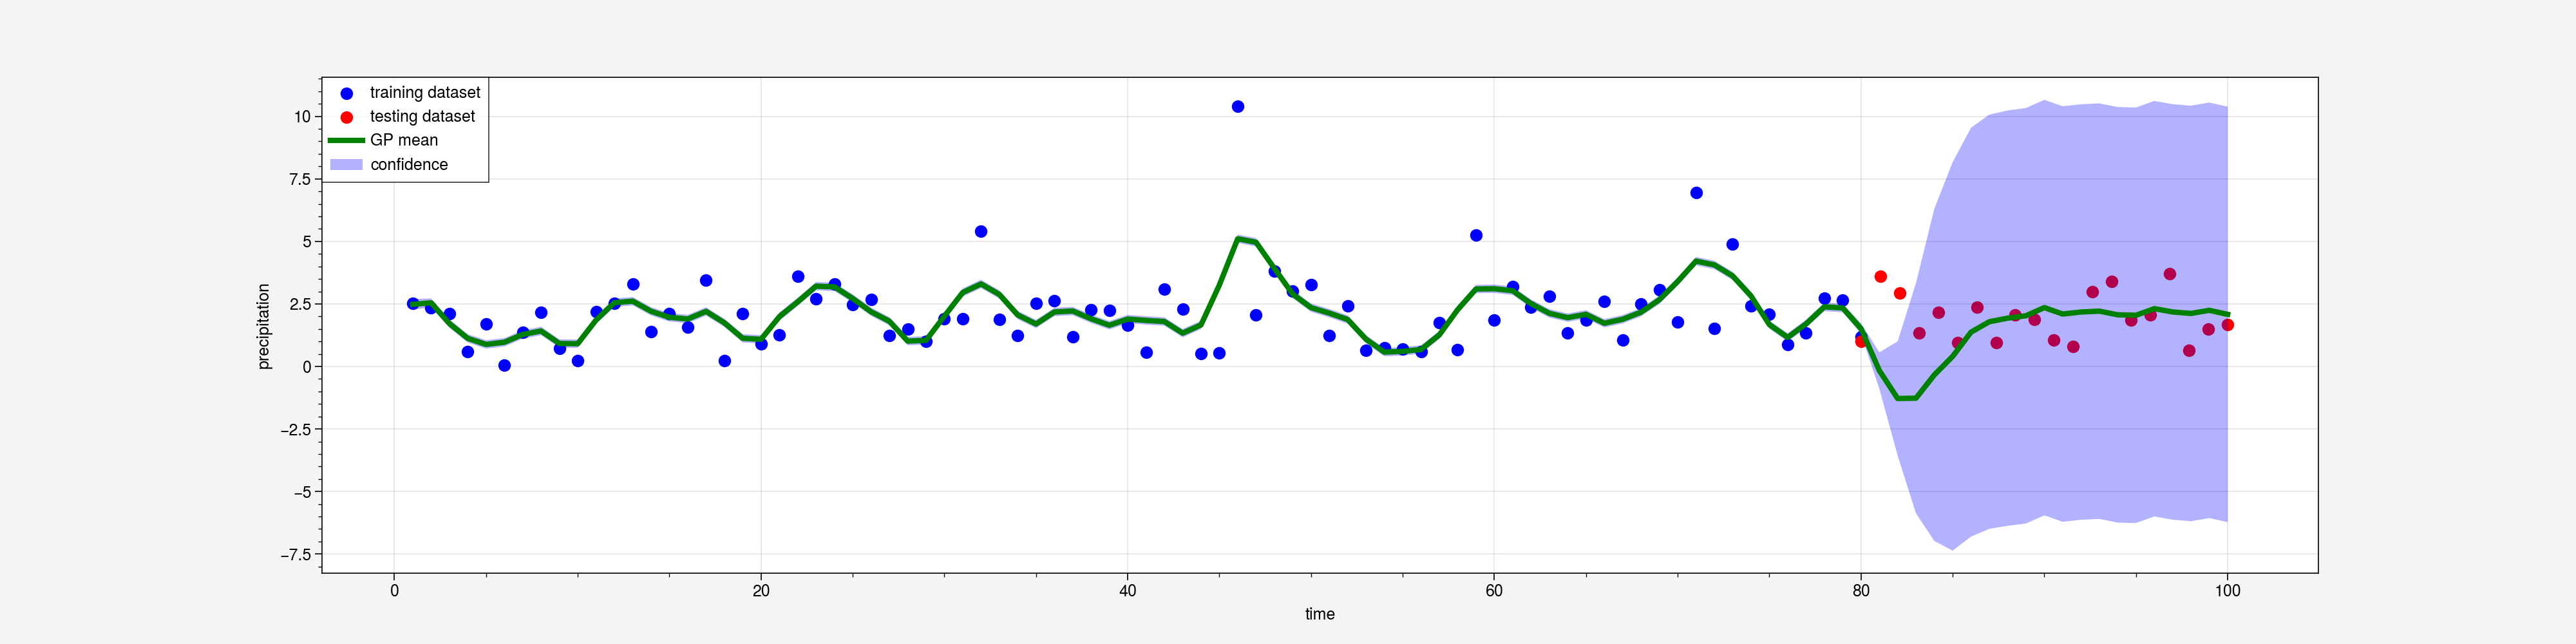

In [84]:
plt.figure(figsize=(20, 5), dpi=100)
plt.xlabel("time")
plt.ylabel("precipitation")
plt.scatter(x_train, y_train, lw=1, color="b", label="training dataset")
plt.scatter(x_test, y_test, lw=1, color="r", label="testing dataset")
plt.plot(x_all, y_mean, lw=3, color="g", label="GP mean")
plt.fill_between(x_all, (y_mean + y_std).reshape(y_mean.shape[0]), (y_mean - y_std).reshape(y_mean.shape[0]), facecolor="b", alpha=0.3, label="confidence")
plt.legend(loc="upper left")
plt.show()

In [107]:
# Make some predictions by drawing from the distributions 
# the GP has returned for all values (the first 80 were
# actually in the training set, the rest only test set.)
def draw_samples(y_mean, y_std):
    mean = y_mean.reshape(-1)
    cov = np.diag(y_std.reshape(-1))
    y_pred = mvn.rvs(mean, cov, 1)

    return y_pred

In [112]:
def fit_gp(x):
    # x are the hyperparameters: ls1, ls2, v1, v2.
    
    rmse = 0
    for i in range(x.shape[0]):
        kernel = GPy.kern.RBF(1, lengthscale=x[i, 0], variance=x[i, 3]) + GPy.kern.StdPeriodic(1, lengthscale=x[i, 1]) * GPy.kern.PeriodicMatern32(1, lengthscale=x[i, 2], variance=x[i, 4])
        print(x_train, y_train)
        model = GPy.models.GPRegression(x_train.reshape(-1, 1), y_train.reshape(-1, 1), kernel=kernel, normalizer= True, noise_var=0.05)
        y_mean, y_std = model.predict(x_all.reshape(-1, 1))
        y_pred = draw_samples(y_mean, y_std)
        
        # Calculate RMSE — does it even make sense to use RMSE since
        # a GP doesn't make exact predictions, but specifies distributions
        # over functions?
        all_y = np.concatenate([y_train, y_test])
        rmse += np.sum(all_y - y_pred)

    return rmse

In [113]:
domain = [
    {'name': 'lengthscale1', 'type': 'continuous', 'domain': (0.,5.)},
    {'name': 'lengthscale2', 'type': 'continuous', 'domain': (0.,1.)},
    {'name': 'lengthscale3', 'type': 'continuous', 'domain': (0.,5.)},
    {'name': 'variance1', 'type': 'continuous', 'domain': (0.,1.)},
    {'name': 'variance2', 'type': 'continuous', 'domain': (0.,1.)}]

We, then, create the GPyOpt object and run the optimization procedure. It might take a while.

In [114]:
opt = GPyOpt.methods.BayesianOptimization(f = fit_gp,            # function to optimize       
                                          domain = domain,         # box-constraints of the problem
                                          acquisition_type ='LCB',       # LCB acquisition
                                          acquisition_weight = 0.1)   # Exploration exploitation

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53. 54.
 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71. 72.
 73. 74. 75. 76. 77. 78. 79. 80.] [ 2.5363148   2.342607    2.1046946   0.58171395  1.7038079   0.05325638
  1.3639283   2.1721504   0.7188085   0.2295015   2.1893191   2.5296715
  3.3076558   1.38088     2.1151185   1.5825262   3.4533266   0.22054508
  2.1191972   0.9078552   1.265772    3.6015528   2.7053326   3.293295
  2.4771498   2.676711    1.2259117   1.4915038   1.00275465  1.8989016
  1.9116844   5.4180466   1.8768007   1.2333791   2.514909    2.6286534
  1.1939812   2.2650787   2.2315884   1.6406779   0.5606757   3.079583
  2.2845868   0.50961153  0.5302767  10.4083316   2.0604371   3.8112194
  3.0029878   3.2792905   1.22800475  2.4277992   0.6429311   0.74122477
  0.68944323  0.5824277  

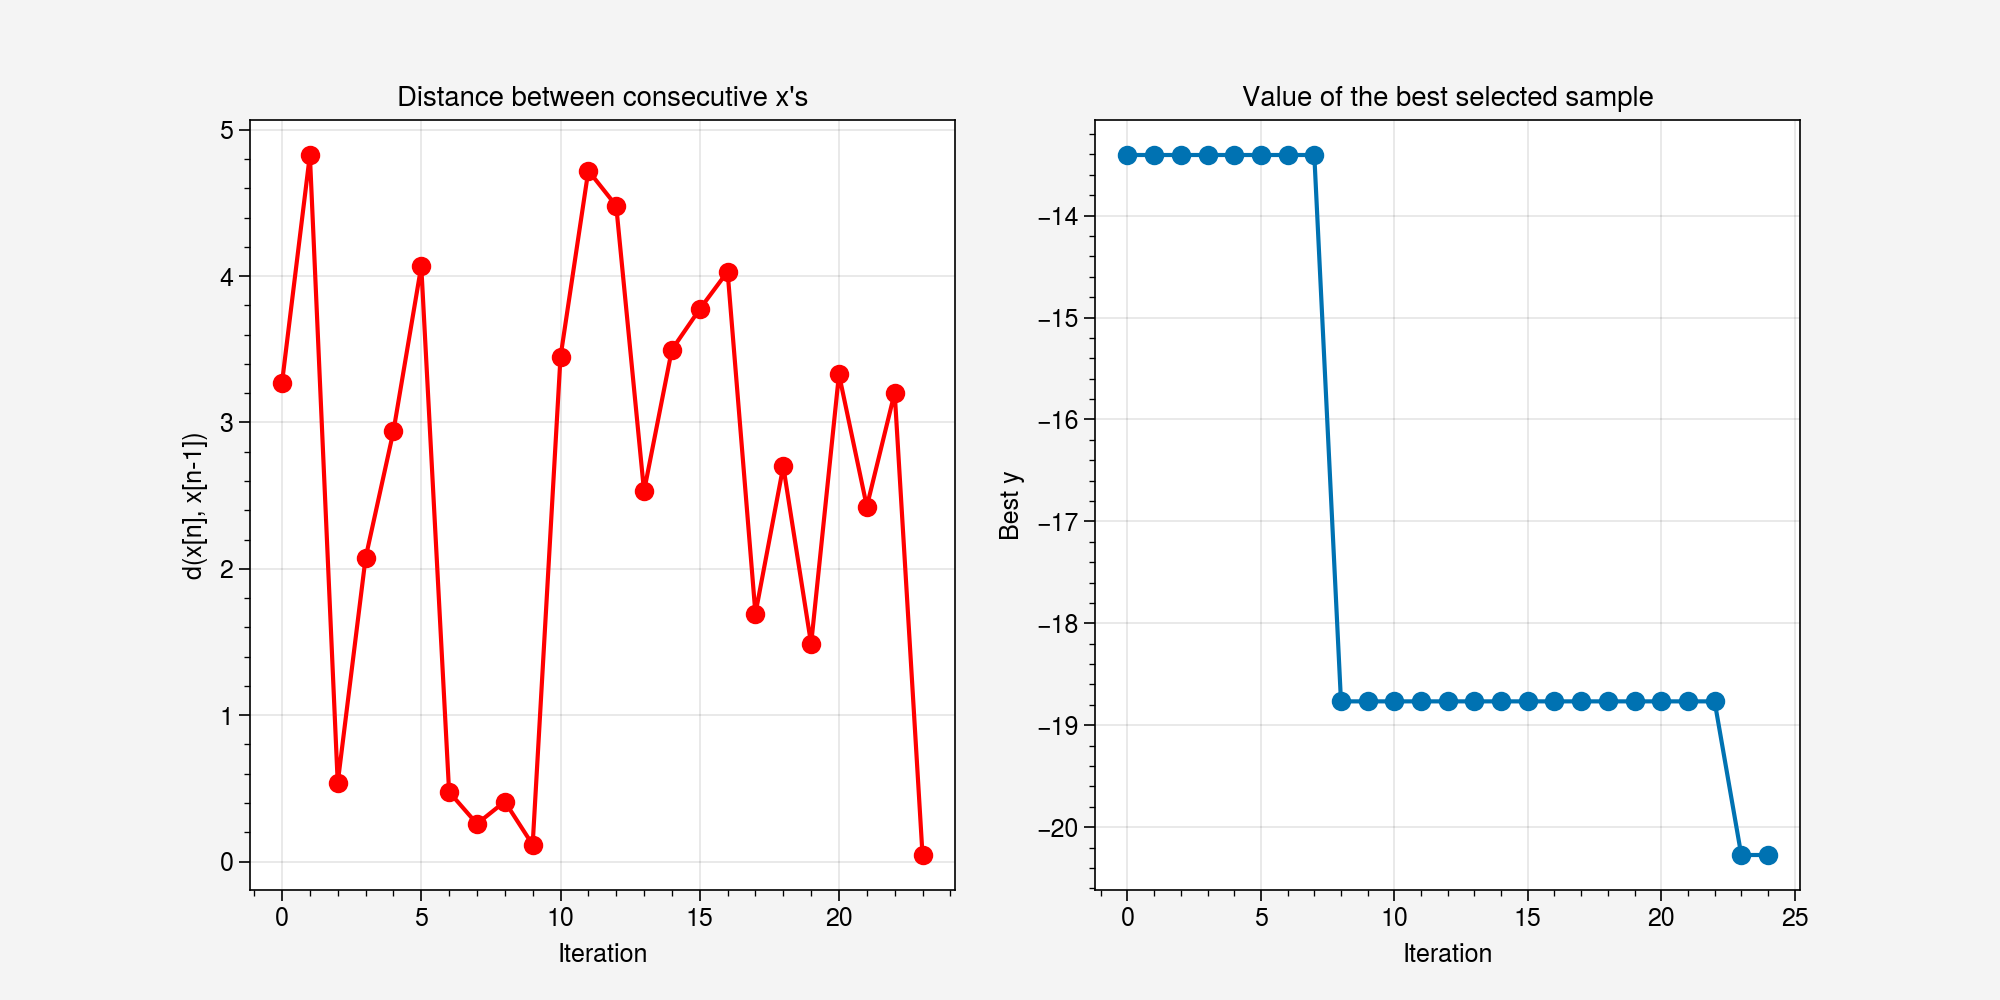

In [111]:
# it may take a few seconds
opt.run_optimization(max_iter=20)
opt.plot_convergence()

Let's show the best parameters found. They differ significantly from the default parameters.

In [103]:
optimal_hparams = opt.X[np.argmin(opt.Y)]
print(f"ls1: {str(optimal_hparams[0])}, ls2: {str(optimal_hparams[1])}, ls3: {str(optimal_hparams[2])}, v1: {str(optimal_hparams[3])}, v2: {str(optimal_hparams[4])}\n")

ls1: 3.8315612718518133, ls2: 0.4142596662560972, ls3: 0.6729013659155081, v1: 0.31893203448577845, v2: 0.5455182387168416



In [104]:
kernel = GPy.kern.RBF(1, lengthscale=optimal_hparams[0], variance=optimal_hparams[3]) + \
             GPy.kern.StdPeriodic(1, lengthscale=optimal_hparams[1]) * \
             GPy.kern.PeriodicMatern32(1, lengthscale=optimal_hparams[2], variance=optimal_hparams[4])

model = GPy.models.GPRegression(x_train.reshape(-1, 1), y_train.reshape(-1, 1), kernel=kernel, normalizer=True,
                                noise_var=0.05)
y_mean, y_std = model.predict(x_all.reshape(-1, 1))

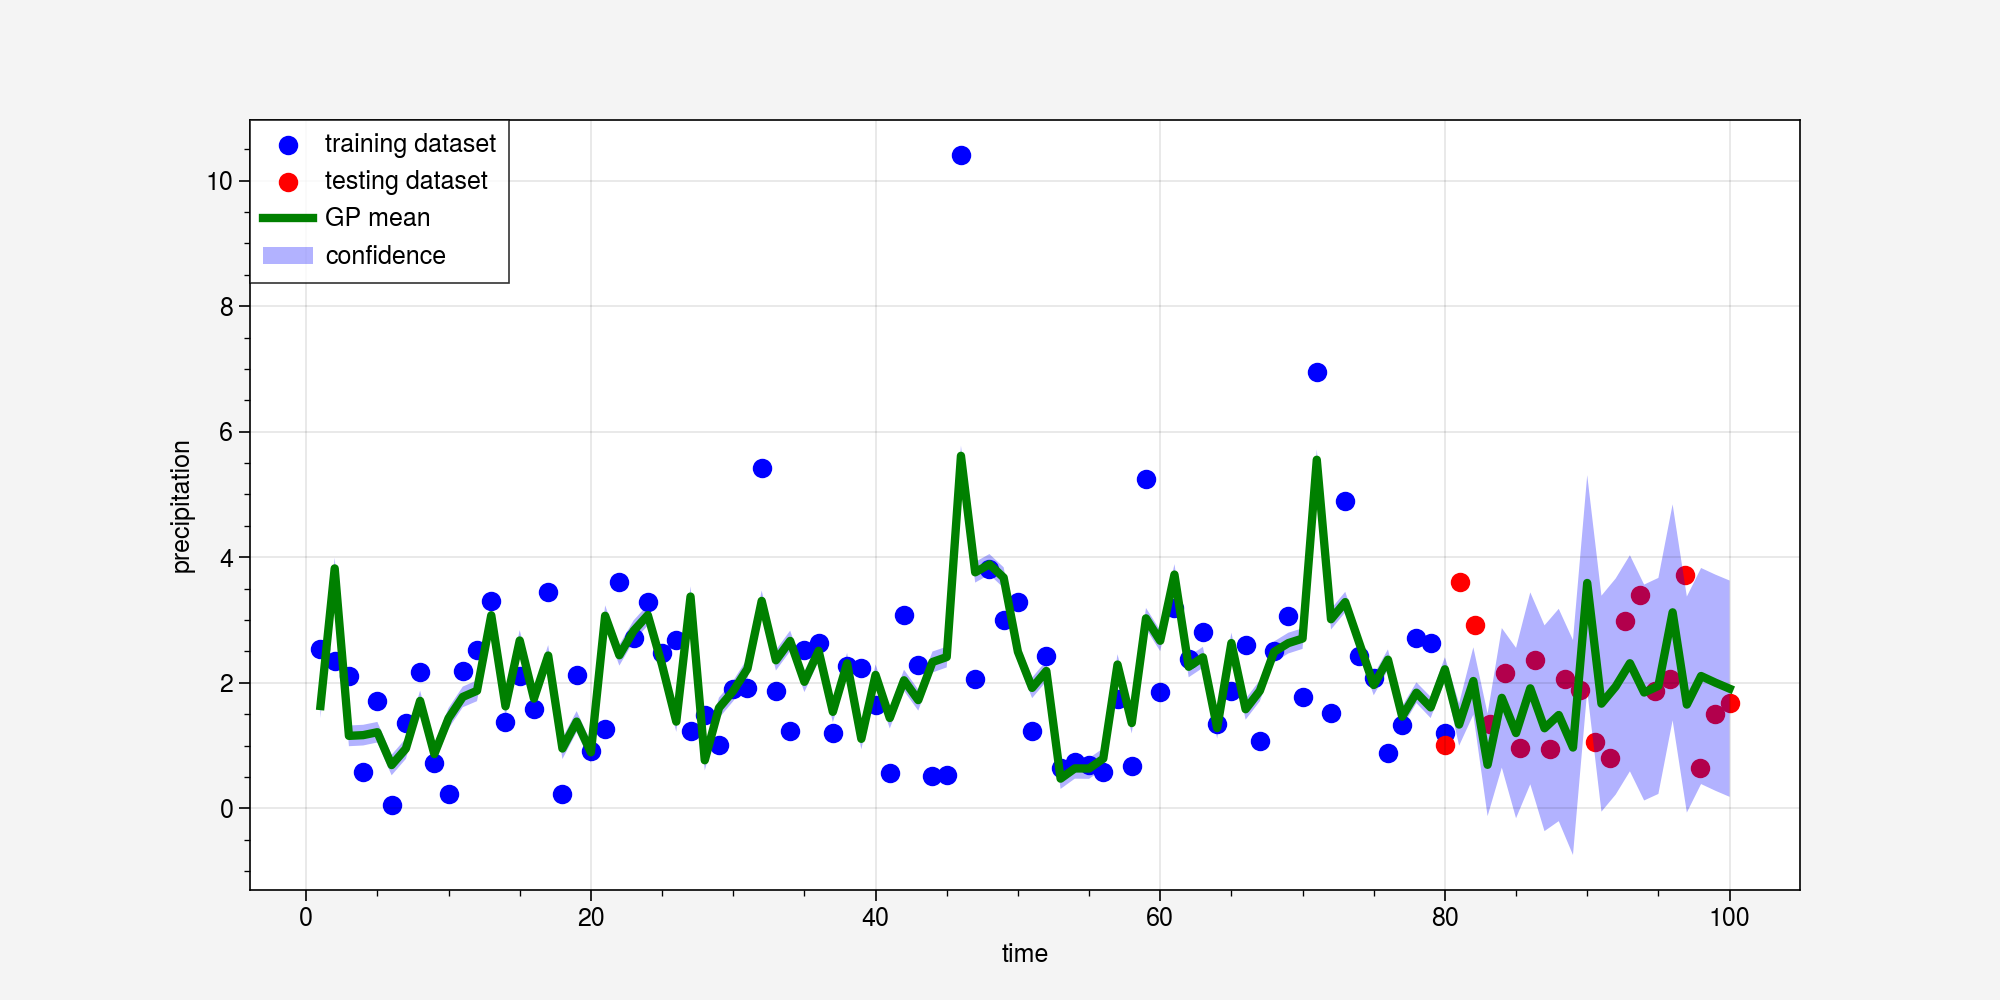

In [105]:
plt.figure(figsize=(10, 5), dpi=100)
plt.xlabel("time")
plt.ylabel("precipitation")
plt.scatter(x_train, y_train, lw=1, color="b", label="training dataset")
plt.scatter(x_test, y_test, lw=1, color="r", label="testing dataset")
plt.plot(x_all, y_mean, lw=3, color="g", label="GP mean")
plt.fill_between(x_all, (y_mean + y_std).reshape(y_mean.shape[0]), (y_mean - y_std).reshape(y_mean.shape[0]), facecolor="b", alpha=0.3, label="confidence")
plt.legend(loc="upper left")
plt.show()